# YOLO (custom implementation)

First we need to prepare a dataset. We are going to use Pascal VOC 2012 version rather than COCO due to its size.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import xml.etree.ElementTree as ET
import os

from PIL import Image

!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
!tar -xf VOCtrainval_11-May-2012.tar

--2023-11-09 19:47:45--  http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1999639040 (1.9G) [application/x-tar]
Saving to: ‘VOCtrainval_11-May-2012.tar’

VOCtrainval_11-May- 100%[===================>]   1.86G  27.9MB/s    in 70s     

2023-11-09 19:48:56 (27.1 MB/s) - ‘VOCtrainval_11-May-2012.tar’ saved [1999639040/1999639040]



In [ ]:
# Checking if there are some issues while loading data

for file in os.listdir('/content/VOCdevkit/VOC2012/Annotations'):
  if file.endswith('.xml')==False:
    print("Error occured")

### Let's define a parser function:
**parser()**: This function is designed to parse the XML annotation files of the Pascal VOC dataset.

It creates a mapping from object labels (like 'aeroplane', 'bicycle', etc.) to integers. This is useful for converting categorical labels to numerical labels which are easier to handle in machine learning models.
It iterates through each XML file in the given directory, parsing each file to extract the bounding box annotations (coordinates) and labels for objects in the images.
For each object in an image, it extracts and converts the coordinates of the bounding box (xmin, ymin, xmax, ymax) from the XML file. It handles potential errors in this process, like parsing errors or missing data, and prints informative messages in case of such exceptions.
The extracted data for each image is stored in a dictionary with image file names (minus the .xml extension) as keys and the list of bounding box coordinates and labels as values.
Data Structure: The function returns two items:

**img_annotations**: A dictionary where each key is an image file name and each value is a list of dictionaries, each containing the bounding box and label of an object in the image.

**label_map**: A dictionary mapping the string labels to integers.
Inverse Label Map and Sample Output: After parsing, the code creates an inverse mapping from label indices back to string labels. This can be useful for interpretation purposes. It also prints the annotations for a specific image file (in this case, '2012_000051') as a demonstration of the output.

In [ ]:
# Preparing the dataset

directory = 'VOCdevkit/VOC2012/Annotations'

def parser(directory):
    img_annotations = {}
    label_map = {
        'aeroplane': 0, 'bicycle': 1, 'bird': 2, 'boat': 3,
        'bottle': 4, 'bus': 5, 'car': 6, 'cat': 7, 'chair': 8,
        'cow': 9, 'diningtable': 10, 'dog': 11, 'horse': 12,
        'motorbike': 13, 'person': 14, 'pottedplant': 15,
        'sheep': 16, 'sofa': 17, 'train': 18, 'tvmonitor': 19
    }

    for file in os.listdir(directory):
        if file.endswith('.xml'):
            file_path = os.path.join(directory, file)

            try:
                tree = ET.parse(file_path)
                root = tree.getroot()
            except ET.ParseError:
                print(f'Error parsing {file}')
                continue

            boxes = []
            for obj in root.findall('object'):
                label = obj.find('name').text
                box = obj.find('bndbox')

                if label is None or box is None:
                  print(f'The information is abscent for {file}')
                  continue

                try:
                    xmin = int(round(float(box.find('xmin').text)))
                    ymin = int(round(float(box.find('ymin').text)))
                    xmax = int(round(float(box.find('xmax').text)))
                    ymax = int(round(float(box.find('ymax').text)))
                except (TypeError, ValueError):
                    print(f'Exception appeared for {file}')
                    continue

                boxes.append({
                    'label': label_map.get(label, -1),
                    'xmin': xmin,
                    'ymin': ymin,
                    'xmax': xmax,
                    'ymax': ymax
                })

            if boxes:
                img_annotations[file[:-4]] = boxes

    return img_annotations, label_map

annotations, labels = parser(directory)
inverse_label_map = {v: k for k, v in labels.items()}
print(annotations.get('2012_000051'))

[{'label': 14, 'xmin': 9, 'ymin': 206, 'xmax': 33, 'ymax': 261}, {'label': 14, 'xmin': 103, 'ymin': 201, 'xmax': 123, 'ymax': 245}]


Now we also should modify the way the data is stored since the YOLO model requires a bit different input.
The **transform_annotation** function is essential for further modeling, it takes the bounding box annotations and transforms them into a specific format that YOLO requires for training.

**image_width** and **image_height**: Dimensions of the image. These are used to normalize the bounding box coordinates.

**boxes**: A list of dictionaries, each containing the label and coordinates (xmin, ymin, xmax, ymax) of a bounding box in the image.

**S**: The size of the grid into which the image is divided. YOLO divides the image into an SxS grid.

**B**: The number of bounding boxes the model predicts per grid cell.

**C**: The number of classes in the dataset.

In [ ]:
# Preparing the data for YOLO

def transform_annotation(image_width, image_height, boxes, S=7, B=2, C=20):
  target = torch.zeros((S, S, B * 5 + C))
  cell_size = 1.0 / S

  for box in boxes:
    label = box['label']
    x_center = (box['xmin'] + box['xmax']) / 2 / image_width
    y_center = (box['ymin'] + box['ymax']) / 2 / image_height
    width = (box['xmax'] - box['xmin']) / image_width
    height = (box['ymax'] - box['ymin']) / image_height

    grid_x = int(x_center / cell_size)
    grid_y = int(y_center / cell_size)

    for b in range(B):
      if target[grid_x, grid_y, b * 5 + 4] == 0:
        target[grid_x, grid_y, b * 5 : b * 5 + 5] = torch.tensor([x_center, y_center, width, height, 1])
        target[grid_x, grid_y, B * 5 + label] = 1
        break

  return target

The **YOLODataset** class in the code is a custom dataset for training a YOLO model, inheriting from PyTorch's Dataset class. Key functionalities include:

Initialization (__init__): It takes annotation and image directories, grid size (S), bounding boxes per cell (B), number of classes (C), and image transformations. The parser function is used to load and process annotations.

Data Retrieval (__getitem__): For each index, it loads an image, applies transformations (resizing, color adjustments, flipping, etc.), and uses transform_annotation to convert bounding box data into YOLO's required format.

Dataset Preparation: The code defines a series of image transformations for data augmentation and converts images to tensors.

DataLoader Setup: A DataLoader is created with the custom dataset for efficient data handling during model training, including batching and shuffling.

In [ ]:
class YOLODataset(Dataset):
    def __init__(self, annotation_dir, image_dir, S=7, B=2, C=20, transform=None):
        # The parser function returns two values, annotations and label_map
        annotations, self.label_map = parser(annotation_dir)  # separate them here
        self.annotations = annotations  # This should be just the annotations dictionary
        self.image_dir = image_dir
        self.S = S
        self.B = B
        self.C = C
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        image_id, boxes = list(self.annotations.items())[idx]
        image_path = os.path.join(self.image_dir, f'{image_id}.jpg')
        image = Image.open(image_path).convert('RGB')  # Make sure this is a PIL image

        # Get the dimensions before applying transformations that convert to a tensor
        image_width, image_height = image.size

        # Apply the transformations
        if self.transform:
            image = self.transform(image)  # Now image is a tensor after this transformation

        # Now you can no longer access image.size directly since image is a tensor
        # image_width and image_height from before are used to create the target
        target = transform_annotation(image_width, image_height, boxes, self.S, self.B, self.C)

        return image, target

In [ ]:
transform = transforms.Compose([
    transforms.Resize((448, 448)),   # Higher resolution if possible
    transforms.ColorJitter(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.95, 1.05)),
    transforms.ToTensor()
])

dataset = YOLODataset(
    annotation_dir = directory,
    image_dir = '/content/VOCdevkit/VOC2012/JPEGImages',
    transform = transform
)

data_loader = DataLoader(dataset, batch_size = 5, shuffle=True)

In [ ]:
data_loader

Next we define the core of our model - CNN. In the original paper 24 convolutional layers were used followed by 2 fully connected ones. Due to resource limitations, our structure is much simpler and the main idea is to reproduce a model even with insufficient accuracy. Later, another architecure can be defined in order to improve predictability of the model.

The **CustomYOLOCNN** class defines a convolutional neural network for the YOLO object detection model. It includes:

* Convolutional Layers: A series of convolutional layers with Batch Normalization and LeakyReLU activation functions, followed by MaxPooling. These layers are designed to extract features from the input images.

* Weight Initialization: Weights of the layers are initialized using specific methods for Conv2d and BatchNorm2d layers to optimize performance.

* Feature Size Determination: The network uses a dummy input to determine the size of the feature maps after the convolutional layers.

* Classifier Layer: A fully connected layer that flattens the output of the convolutional layers and then maps it to the final output size, which corresponds to the grid size, number of bounding boxes per grid cell, and number of classes.

* Forward Pass: In the forward method, the input data is passed through the convolutional layers and the classifier, and then reshaped into the final output format expected by the YOLO model.

In [ ]:
from torch.nn.modules.activation import LeakyReLU
# Defining the CNN

import torch.nn as nn
import torch.nn.functional as f

class CustomYOLOCNN(nn.Module):
  def __init__(self, S=7, B=2, C=20):
    super(CustomYOLOCNN, self).__init__()
    self.S = S
    self.B = B
    self.C = C

    # In the original paper YOLO had 24 convolutional layers and 2 fully connected ones

    self.features = nn.Sequential(
      nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=2),
      nn.BatchNorm2d(64),
      nn.LeakyReLU(0.1),
      nn.MaxPool2d(kernel_size=2, stride=2),

      nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=2),
      nn.BatchNorm2d(128),
      nn.LeakyReLU(0.1),
      nn.MaxPool2d(kernel_size=2, stride=2),

      nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=2),
      nn.BatchNorm2d(128),
      nn.LeakyReLU(0.1),
      nn.MaxPool2d(kernel_size=2, stride=2)
    )

    # Initialize weights
    self._initialize_weights()

    with torch.no_grad():
      dummy_input = torch.zeros((1, 3, 448, 448))
      dummy_features = self.features(dummy_input)
      self._linear_input_features = dummy_features.view(1, -1).size(1)

    self.classifier = nn.Sequential(
      nn.Flatten(),
      nn.Linear(self._linear_input_features, 4096),
      nn.LeakyReLU(0.1),
      nn.Dropout(0.5),
      nn.Linear(4096, S * S * (C + B * 5))
    )

  def _initialize_weights(self):
    for m in self.modules():
      if isinstance(m, nn.Conv2d):
          nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
      elif isinstance(m, nn.BatchNorm2d):
          nn.init.constant_(m.weight, 1)
          nn.init.constant_(m.bias, 0)

  def forward(self, x):
    x = self.features(x)
    x = x.view(x.size(0), -1)
    x = self.classifier(x)
    # Reshape x to the target's shape
    x = x.view(-1, self.S, self.S, (self.B * 5 + self.C))  # Reshape to the correct shape
    return x

Now let's initialize it and add a criterion and an optimizer:

In [ ]:
model = CustomYOLOCNN()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

The **YOLOTrainer** class encapsulates the training process of the YOLO model:

* Initialization: It initializes with the model, a data loader, loss criterion, optimizer, and device (CPU/GPU).

Training Process:

* train_epoch: Runs one training epoch. It sets the model to training mode, iterates over the dataset, performs forward and backward passes, computes loss, updates model weights, and prints loss statistics every 10 mini-batches.

* save_checkpoint: Saves the model's state at the end of each epoch.

* train: Runs the training for a specified number of epochs, stepping the learning rate scheduler at each epoch.

* Learning Rate Scheduler: Outside of the class, a step learning rate scheduler is defined to adjust the learning rate at regular intervals (every 30 steps in this case).

* Loss Computation: A placeholder for YOLO-specific loss computation is included, currently using the provided criterion for calculating loss.

In [ ]:
# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

class YOLOTrainer:
    def __init__(self, model, dataloader: DataLoader, criterion, optimizer, device):
        self.model = model
        self.dataloader = dataloader
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device

    def train_epoch(self, epoch):
        self.model.train()  # Set the model to training mode
        running_loss = 0.0

        for i, (images, targets) in enumerate(self.dataloader):
            images, targets = images.to(self.device), targets.to(self.device)

            # Zero the parameter gradients
            self.optimizer.zero_grad()

            # Forward pass
            outputs = self.model(images)

            # Compute the loss
            loss = self.compute_loss(outputs, targets)

            # Backward pass and optimize
            loss.backward()
            self.optimizer.step()

            # Print statistics
            running_loss += loss.item()
            if i % 10 == 9:  # Print every 10 mini-batches
                print(f'Epoch: {epoch + 1}, Batch: {i + 1}, Loss: {running_loss / 10}')
                running_loss = 0.0

        # Save a checkpoint at the end of each epoch
        self.save_checkpoint(epoch)

    def save_checkpoint(self, epoch, filename='yolo_checkpoint_modified.pth.tar'):
        state = {
            'epoch': epoch,
            'state_dict': self.model.state_dict(),
            'optimizer': self.optimizer.state_dict(),
        }
        torch.save(state, filename)

    def train(self, epochs, scheduler):
        for epoch in range(epochs):
            print(f'Starting epoch {epoch + 1}/{epochs}')
            self.train_epoch(epoch)
            scheduler.step()  # Step the learning rate scheduler
            print('--------------------------------')

    def compute_loss(self, outputs, targets):
        # Implement the YOLO-specific loss calculation here
        return self.criterion(outputs, targets)

Now we can train our model:

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

trainer = YOLOTrainer(model, data_loader, criterion, optimizer, device)
trainer.train(epochs=10, scheduler=scheduler)

Starting epoch 1/10
Epoch: 1, Batch: 10, Loss: 0.04316236609593034
Epoch: 1, Batch: 20, Loss: 0.014568587951362132
Epoch: 1, Batch: 30, Loss: 0.015521104354411364
Epoch: 1, Batch: 40, Loss: 0.012350083049386739
Epoch: 1, Batch: 50, Loss: 0.01140801552683115
Epoch: 1, Batch: 60, Loss: 0.010437277983874083
Epoch: 1, Batch: 70, Loss: 0.00940667325630784
Epoch: 1, Batch: 80, Loss: 0.009327871166169644
Epoch: 1, Batch: 90, Loss: 0.008962976466864347
Epoch: 1, Batch: 100, Loss: 0.0075774171855300665
Epoch: 1, Batch: 110, Loss: 0.008519421797245741
Epoch: 1, Batch: 120, Loss: 0.008313609566539527
Epoch: 1, Batch: 130, Loss: 0.007589523633942008
Epoch: 1, Batch: 140, Loss: 0.006892628083005547
Epoch: 1, Batch: 150, Loss: 0.007733690924942494
Epoch: 1, Batch: 160, Loss: 0.006540687428787351
Epoch: 1, Batch: 170, Loss: 0.006785114156082272
Epoch: 1, Batch: 180, Loss: 0.007750144833698869
Epoch: 1, Batch: 190, Loss: 0.006741072004660964
Epoch: 1, Batch: 200, Loss: 0.007330129016190767
Epoch: 1, B

In [ ]:
# This is just checking whether the input path exists or not

file_path = '/content/VOCdevkit/VOC2012/JPEGImages'

if os.path.exists(file_path):
    print(f"The file exists: {file_path}")
else:
    print(f"The file does not exist: {file_path}")

The file exists: /content/VOCdevkit/VOC2012/JPEGImages


# Predictions

This part of the code describes a complete process for loading a trained YOLO model, preprocessing an input image, making predictions, decoding these predictions, and visualizing the results:

Load Trained Model:

* load_trained_model function loads a pre-trained YOLO model from a checkpoint file. It initializes a CustomYOLOCNN model, loads the saved state, and sets it to evaluation mode.
Preprocess Image:

* preprocess_image function processes an input image for the model. It opens the image, converts it to RGB, resizes it to the required dimensions (448x448), and converts it to a tensor.
Decode Predictions:

* decode_predictions function interprets the model's output. It reshapes the predictions to match the grid structure, filters bounding boxes based on a confidence threshold, and calculates the actual position of each bounding box in the original image size.
Visualization:

* draw_boxes function visualizes the predicted bounding boxes on the original image. It draws rectangles around detected objects and annotates them with class labels and confidence scores.
Execution Flow:

The model and an input image are loaded.
The model makes predictions on the preprocessed image.
Predictions are decoded to obtain bounding box coordinates and labels.
The original image is reloaded and the bounding boxes are drawn on it for visualization.

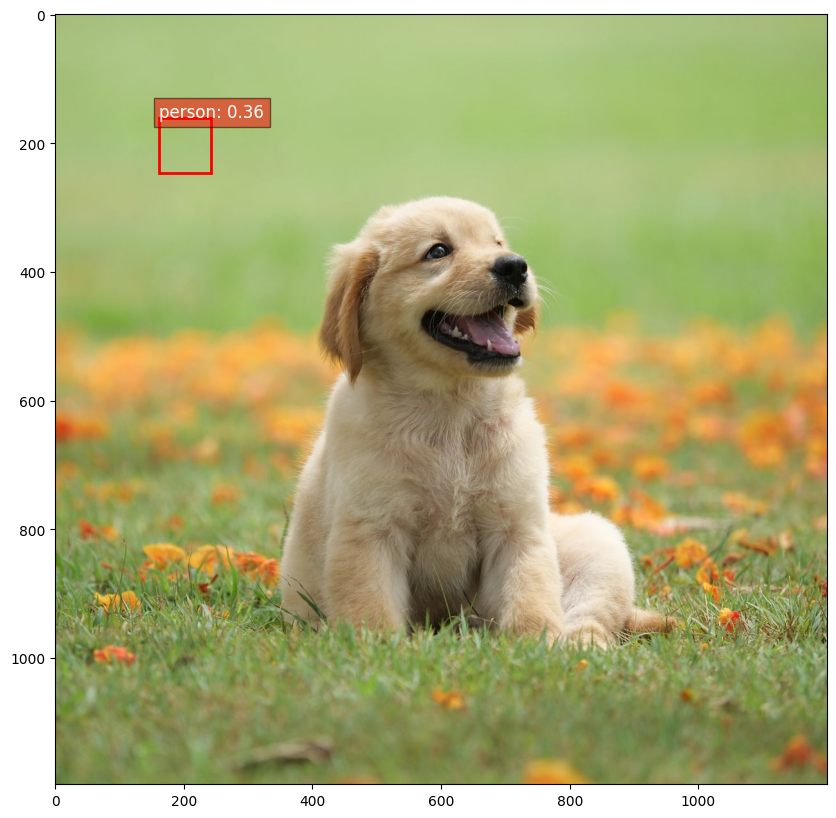

In [ ]:
# Load the trained model from the checkpoint
def load_trained_model(model_path):
    model = CustomYOLOCNN()  # Instantiate your model architecture
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint['state_dict'])
    model.eval()  # Set the model to evaluation mode
    return model

# Preprocess the input image
def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((448, 448)),
        transforms.ToTensor()
    ])
    image = transform(image)
    return image

def decode_predictions(predictions, S=7, B=2, C=20, threshold=0.2):
    """
    Decodes the predictions of the YOLO model.

    Args:
    - predictions: the output tensor from the YOLO model
    - S, B, C: the dimensions of the prediction grid (SxS grid, B bounding boxes, C classes)
    - threshold: the threshold for considering detected objects

    Returns:
    - A list of dictionaries containing boxes with labels and coordinates
    """
    predictions = predictions.reshape(-1, S, S, B*5 + C)
    boxes = []
    for i in range(S):
        for j in range(S):
            for b in range(B):
                box_data = predictions[0, i, j, b*5:(b+1)*5]
                confidence = box_data[4]
                if confidence < threshold:
                    continue

                # Get the class label with the highest score
                class_probs = predictions[0, i, j, B*5:]
                class_label = torch.argmax(class_probs).item()

                # Convert coordinates
                cell_size = 448 / S  # Assuming input images are resized to 448x448
                x_center = (box_data[0] + j) * cell_size
                y_center = (box_data[1] + i) * cell_size
                width = box_data[2] * 448
                height = box_data[3] * 448

                xmin = x_center - width / 2
                ymin = y_center - height / 2
                xmax = x_center + width / 2
                ymax = y_center + height / 2

                boxes.append({
                    'label': class_label,
                    'confidence': confidence.item(),
                    'xmin': max(0, int(xmin)),
                    'ymin': max(0, int(ymin)),
                    'xmax': min(448, int(xmax)),  # Make sure the box doesn't go out of the image
                    'ymax': min(448, int(ymax))
                })

    # Here you would typically apply Non-Maximum Suppression (NMS) to reduce overlapping boxes
    # But for simplicity, we're skipping this step

    return boxes

# Function to draw bounding boxes on the image
def draw_boxes(original_image, boxes, class_map):
    plt.figure(figsize=(10, 10))
    plt.imshow(original_image)
    ax = plt.gca()

    # For each box, add a rectangle and label - this is an example, adjust according to your decode_predictions function
    for box in boxes:
        label = class_map[box['label']]
        confidence = box['confidence']
        xmin, ymin, xmax, ymax = box['xmin'], box['ymin'], box['xmax'], box['ymax']
        rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.text(xmin, ymin, f"{label}: {confidence:.2f}", color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))

    plt.show()

# Path to the model checkpoint and image file
model_path = '/content/yolo_checkpoint_modified.pth.tar'
image_path = '/content/dog-photo.jpg'

# Load the model and preprocess the image
model = load_trained_model(model_path)
input_image = preprocess_image(image_path)

# Assuming you have a function that can decode the raw model output into bounding boxes
with torch.no_grad():
    predictions_tensor = model(input_image.unsqueeze(0))  # Add a batch dimension
boxes = decode_predictions(predictions_tensor)  # Decode predictions

# Draw the boxes on the original image
original_image = Image.open(image_path).convert('RGB')  # Convert image to RGB
draw_boxes(original_image, boxes, inverse_label_map)



This code segment introduces a Non-Maximum Suppression (NMS) function to refine the bounding box predictions from a YOLO model and visualizes the results (impovement in comparison to the previous code cell).

* Non-Maximum Suppression (nms) Function:
Takes a list of predicted bounding boxes and an IoU (Intersection over Union) threshold.
Converts the bounding box data into a tensor for processing.
Sorts the boxes by their confidence scores.
Iteratively selects the box with the highest score, removes boxes that overlap with it above the IoU threshold, and keeps the selected box.
Continues until all boxes are either selected or discarded.

* Intersection over Union (bbox_iou) Function: Calculates the IoU between two bounding boxes. Determines the coordinates of the intersection rectangle and calculates its area. Computes the area of both bounding boxes and calculates the IoU as the intersection area over the union area.
Applying NMS:

* The decode_predictions function's output (list of bounding boxes) is passed to the nms function with a specified IoU threshold.
The nms function refines this list by removing overlapping boxes, based on the threshold.

* Visualization: The refined bounding box predictions (after applying NMS) are visualized on the original image using the draw_boxes function.

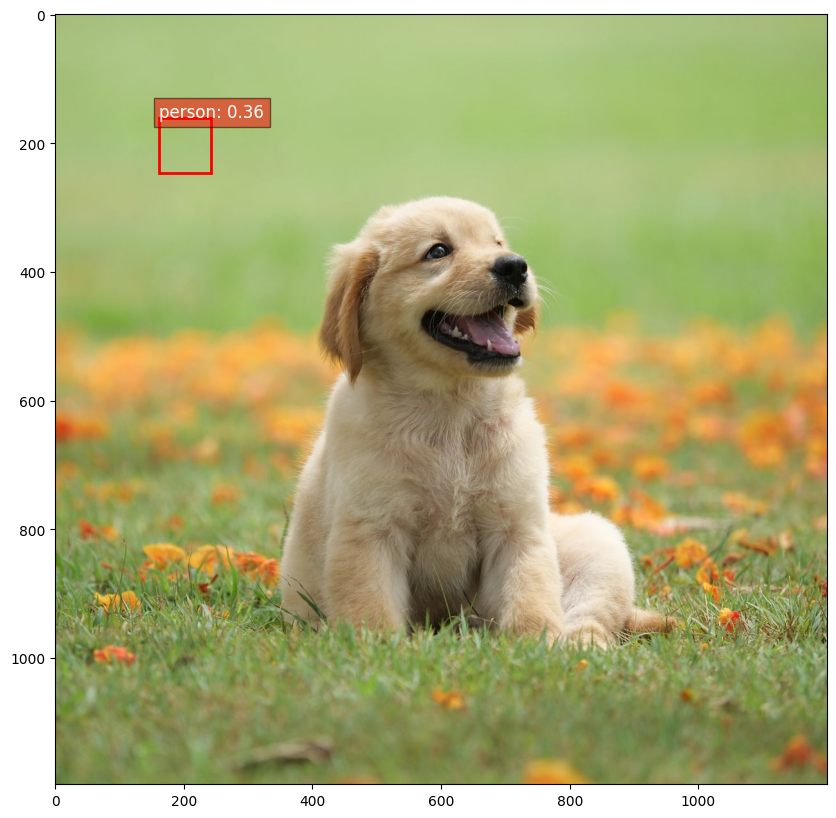

In [ ]:
import torch

def nms(boxes, iou_threshold):
    if not boxes:
        return []

    # Convert to tensors from a list of dictionaries
    boxes_data = torch.tensor([(box['xmin'], box['ymin'], box['xmax'], box['ymax'], box['confidence']) for box in boxes])
    scores = boxes_data[:, 4]

    # Sort your scores and corresponding indexes
    _, sort_ids = scores.sort(descending=True)

    keep = []
    while sort_ids.numel() > 0:
        i = sort_ids[0]  # take the top-scored box
        keep.append(i)

        if sort_ids.numel() == 1:
            break

        # Calculate the IoU of this box with the rest
        ious = bbox_iou(boxes_data[i].unsqueeze(0), boxes_data[sort_ids[1:]])
        # Keep only the ones below the threshold
        below_threshold = ious < iou_threshold
        sort_ids = sort_ids[1:][below_threshold]

    return [boxes[i] for i in keep]

# Function to calculate IoU
def bbox_iou(box1, box2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.
    """
    b1_x1, b1_y1, b1_x2, b1_y2 = box1[:, 0], box1[:, 1], box1[:, 2], box1[:, 3]
    b2_x1, b2_y1, b2_x2, b2_y2 = box2[:, 0], box2[:, 1], box2[:, 2], box2[:, 3]

    inter_rect_x1 = torch.max(b1_x1, b2_x1)
    inter_rect_y1 = torch.max(b1_y1, b2_y1)
    inter_rect_x2 = torch.min(b1_x2, b2_x2)
    inter_rect_y2 = torch.min(b1_y2, b2_y2)

    inter_area = torch.clamp(inter_rect_x2 - inter_rect_x1 + 1, min=0) * torch.clamp(inter_rect_y2 - inter_rect_y1 + 1, min=0)

    b1_area = (b1_x2 - b1_x1 + 1) * (b1_y2 - b1_y1 + 1)
    b2_area = (b2_x2 - b2_x1 + 1) * (b2_y2 - b2_y1 + 1)

    iou = inter_area / (b1_area + b2_area - inter_area)

    return iou.squeeze()


# Assuming 'boxes' is the output from the 'decode_predictions' function
boxes = decode_predictions(predictions_tensor)

# Apply NMS
boxes_after_nms = nms(boxes, iou_threshold=0.4)  # Adjust the threshold as necessary

# Draw the boxes on the original image
original_image = Image.open(image_path).convert('RGB')  # Convert image to RGB
draw_boxes(original_image, boxes_after_nms, inverse_label_map)


Finally, this code demonstrates how to apply the trained YOLO model to a sample image from the dataset and visualize the detected objects. This was done to check how well the model performs on the training data, whether it is properly learning or not.

* Sample Image Preparation:  A random sample is selected from the dataset using the data_loader. The sample consists of an input image and its corresponding target, but here only the input image is used.

* Model and Device Setup:
The computing device (GPU or CPU) is determined and the model is moved to this device.
The input image is also transferred to the same device to ensure compatibility with the model.

* Model Prediction:
The model makes predictions on the input image, generating a tensor of predictions while ensuring no gradients are computed (torch.no_grad()).

* Decoding Predictions:
The decode_predictions function is used to convert the model's output into a list of bounding boxes.

* Image Preparation for Visualization:
The input image, which has been transformed by the DataLoader, is converted back to a PIL image for visualization.
The first image in the batch is selected and moved back to CPU memory for this purpose.

* Applying Non-Maximum Suppression (NMS):
NMS is applied to the decoded boxes to filter out overlapping boxes, using a specified IoU threshold.

* Visualization:
The draw_boxes function is used twice: once commented out for the original image before NMS, and once for the image after applying NMS, to draw the final set of bounding boxes on the image.

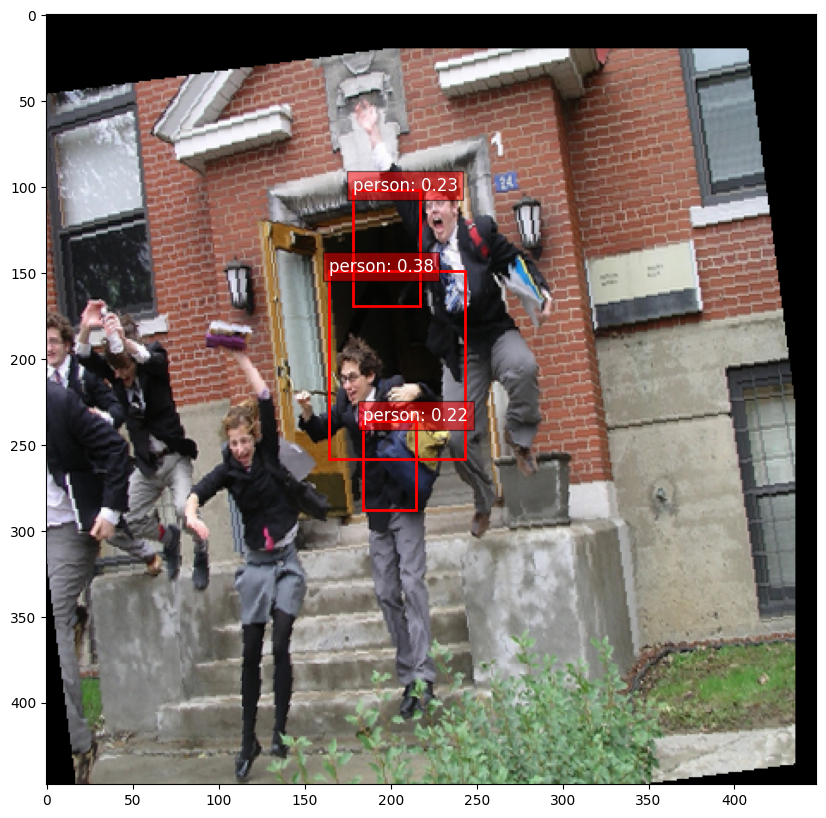

In [ ]:
# Choose a random sample from the dataset
sample = next(iter(data_loader))
input_image, _ = sample  # Ignore the target in this case

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Move the image to the same device as your model
input_image = input_image.to(device)

# Run the model on the input image
with torch.no_grad():
    predictions_tensor = model(input_image)

# Decode the predictions
boxes = decode_predictions(predictions_tensor)

# Convert image to PIL for visualization
# Undo the normalization and other transformations if necessary
# Since DataLoader has already applied transformations, we need to invert them
input_image = input_image[0].cpu()  # Take the first image in the batch
input_image = transforms.ToPILImage()(input_image)

# Draw the boxes on the original image
#draw_boxes(input_image, boxes, inverse_label_map)

# Apply NMS
boxes_after_nms = nms(boxes, iou_threshold=0.1)  # Adjust the threshold as necessary

# Draw the boxes on the original image
original_image = Image.open(image_path).convert('RGB')  # Convert image to RGB
draw_boxes(input_image, boxes_after_nms, inverse_label_map)


# References
* ["You Only Look Once:
Unified, Real-Time Object Detection"
](https://arxiv.org/pdf/1506.02640.pdf) (Original paper for YOLOv1)